# CNN para clasificar espectogramas de notas de guitarra

El siguiente notebook tiene como objetivo crear un modelo CNN de clasificación categorical que permita clasificar notas de una guitarra.

Para ello utilizaremos:
* TensorFlow
* Un dataset propio grabado con 3 guitarras acústicas (una parlor, otra electroacústica y otra acústica).
* Una libreria propia en python con funciones "helpers" que contiene funciones reutilizables que utilizaremos en los diferentes notebooks de este proyecto:

El dataset contiene dos carpetas (train y test):
* **train**: La utilizaremos para entrenar el módelo. Ha sido grabado con una guitarra parlor y otra acústica.
* **test**: La utilizaremos para validar y testear el módelo. Ha sido grabado con una guitarra electroacústica.

Partiremos de la prueba de concepto realizada en el notebook:
https://colab.research.google.com/drive/1fHdwTVE4XzFwDRpZ2tZqart3UuiHCVEx




## 1. Importar helper functions

Empezaremos importando una libreria propia en python con helper functions : https://github.com/lferrerraventos/SoundToTabsTensorFlow/blob/main/notebooks/helpers/helper_functions.py


In [2]:
!wget https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py

--2024-05-03 11:40:41--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6051 (5.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   5.91K  --.-KB/s    in 0s      

2024-05-03 11:40:41 (63.7 MB/s) - ‘helper_functions.py’ saved [6051/6051]



In [ ]:
from helper_functions import unzip_data, predict_and_plot_from_wav_file, plot_confusion_matrix
from helper_functions import show_images_from_path, create_spectrogram, create_spectograms_from_dir
from helper_functions import walk_through_dir, plot_loss_curves

## 2. Descargar dataset

Empezaremos descargando el dataset el cual es accesible en: https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/datasets/Notes.zip


In [1]:
!wget https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/notebooks/datasets/Notes.zip

--2024-05-03 11:40:37--  https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/notebooks/datasets/Notes.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-05-03 11:40:38 ERROR 404: Not Found.



In [ ]:
unzip_data("Notes.zip")

In [ ]:
# Veamos que tenemos en el dataset:
walk_through_dir("Notes/")

There are 2 directories and 0 files in 'Notes/'.
There are 24 directories and 0 files in 'Notes/train'.
There are 0 directories and 37 files in 'Notes/train/6_2'.
There are 0 directories and 38 files in 'Notes/train/5_3'.
There are 0 directories and 38 files in 'Notes/train/2_3'.
There are 0 directories and 41 files in 'Notes/train/6_1'.
There are 0 directories and 39 files in 'Notes/train/1_1'.
There are 0 directories and 41 files in 'Notes/train/3_0'.
There are 0 directories and 38 files in 'Notes/train/3_3'.
There are 0 directories and 40 files in 'Notes/train/1_2'.
There are 0 directories and 39 files in 'Notes/train/4_3'.
There are 0 directories and 39 files in 'Notes/train/1_0'.
There are 0 directories and 41 files in 'Notes/train/2_0'.
There are 0 directories and 37 files in 'Notes/train/4_2'.
There are 0 directories and 37 files in 'Notes/train/2_1'.
There are 0 directories and 39 files in 'Notes/train/4_1'.
There are 0 directories and 42 files in 'Notes/train/6_3'.
There are 0

## 3. Convertir audio a espectogramas

Tal como hicimos en la prueba de concepto ahora utilizaremos la función create_spectograms_from_dir: https://github.com/lferrerraventos/SoundToTabs/blob/bd059d3ef44b7c21441c0400d5701f4c33c9c24f/notebooks/helpers/helper_functions.py#L121
Para convertir todos los ficheros de audio del dataset de notas a espectogramas.

In [ ]:
# definimos directorio principal del dataset para train y test
train_dir = "NoteSpectograms/train"
test_dir = "NoteSpectograms/test"

In [ ]:
from pathlib import Path
def create_spectograms_from_dir2(audio_dir, target_dir):
    audio_dir = Path(audio_dir)
    target_dir = Path(target_dir)
    for audio_file in audio_dir.rglob('*.mp3'):
        save_path = target_dir / audio_file.relative_to(audio_dir).with_suffix('.png')
        save_path.parent.mkdir(parents=True, exist_ok=True)
        create_spectrogram(audio_file, save_path)

create_spectograms_from_dir2("Notes/train", train_dir)
create_spectograms_from_dir2("Notes/test", test_dir)

3_3


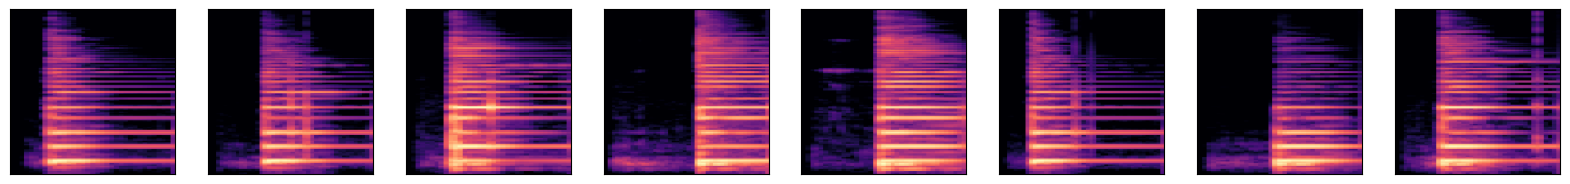

In [ ]:
# Visualizamos espectogramas aleatoriamente
import numpy as np
import random
import os
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
total_class_names = len(class_names)
class_key = random.randint(0, total_class_names)
show_images_from_path(train_dir + "/" + class_names[class_key], class_names[class_key])
print(class_names[class_key])

## 4. Preparar los datos con ImageDataGenerator

Genera lotes de datos de imágenes tensoriales con aumento de datos en tiempo real. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load spectrogram images
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

train_ds.class_indices

Found 938 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


{'1_0': 0,
 '1_1': 1,
 '1_2': 2,
 '1_3': 3,
 '2_0': 4,
 '2_1': 5,
 '2_2': 6,
 '2_3': 7,
 '3_0': 8,
 '3_1': 9,
 '3_2': 10,
 '3_3': 11,
 '4_0': 12,
 '4_1': 13,
 '4_2': 14,
 '4_3': 15,
 '5_0': 16,
 '5_1': 17,
 '5_2': 18,
 '5_3': 19,
 '6_0': 20,
 '6_1': 21,
 '6_2': 22,
 '6_3': 23}

## 5. Definir y entrenar el modelo CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_ds.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
30/30 [==============================] - 5s 105ms/step - loss: 2.9613 - accuracy: 0.1759 - val_loss: 2.0844 - val_accuracy: 0.4250
Epoch 2/5
30/30 [==============================] - 3s 112ms/step - loss: 0.6560 - accuracy: 0.8230 - val_loss: 0.4172 - val_accuracy: 0.8333
Epoch 3/5
30/30 [==============================] - 3s 98ms/step - loss: 0.0391 - accuracy: 0.9936 - val_loss: 0.4262 - val_accuracy: 0.8667
Epoch 4/5
30/30 [==============================] - 3s 92ms/step - loss: 0.0124 - accuracy: 0.9968 - val_loss: 0.2057 - val_accuracy: 0.9333
Epoch 5/5
30/30 [==============================] - 4s 119ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1680 - val_accuracy: 0.9500


## 6. Evaluar y Visualizar

Para evaluar nuestro modelo CNN de multi clasificación podriamos:
* Visualizar en gráficos la precisión y perdida del modelo.
* Evaluar su resultado utilizando métrica de clasificación, como una matriz de confusión.
* Realizar predicciones aleatorias y visualizar el resultado

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy}")

4/4 [==============================] - 0s 76ms/step - loss: 0.1680 - accuracy: 0.9500
Validation accuracy: 0.949999988079071


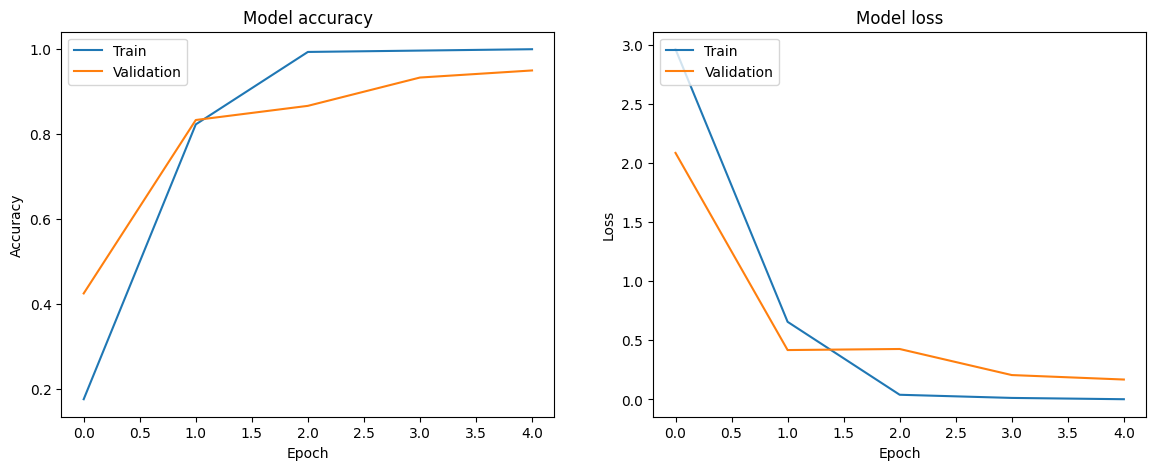

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 [==============================] - 0s 476ms/step


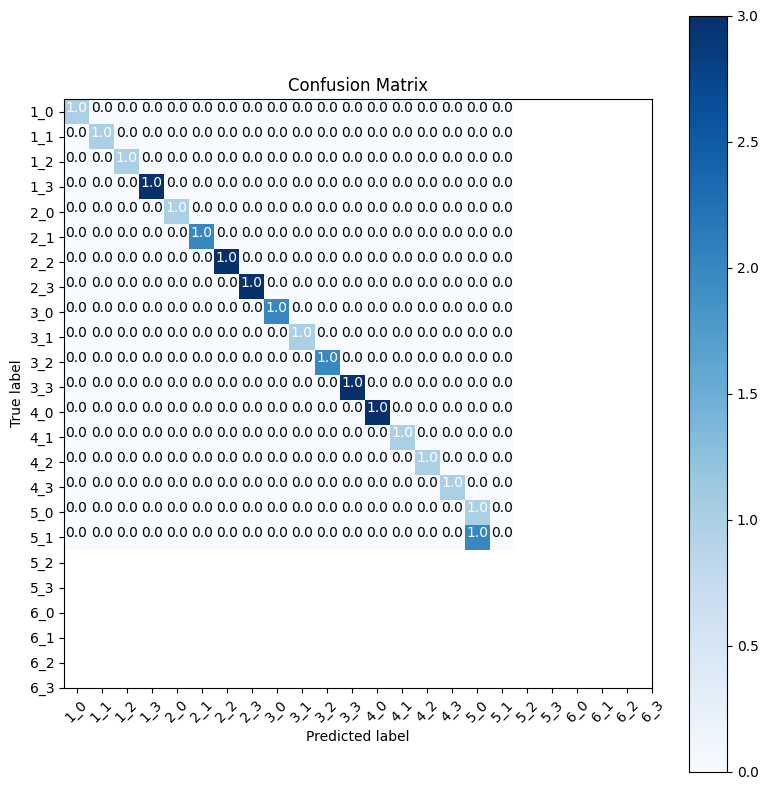

In [ ]:

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

# Generate predictions for all validation images
val_images, val_labels = next(val_ds)  # This assumes that batch_size of val_ds is big enough to cover all validation data
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names=list(train_ds.class_indices.keys()))
plt.show()

## 7. Predicciones

Realizaremos predicciones aleatorias utilizando los espectogramas de la carpeta test grabados con la guitarra electroacústica.

In [ ]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)
predictions, predicted_classes

4/4 [==============================] - 1s 116ms/step


(array([[2.4144879e-07, 4.5051585e-10, 6.2183965e-09, ..., 7.3645288e-01,
         2.3310857e-01, 4.2268652e-03],
        [2.1460272e-13, 4.2022444e-10, 1.5332052e-09, ..., 1.7228668e-08,
         3.1212267e-06, 7.2754025e-05],
        [4.9287860e-15, 4.4860847e-15, 8.5175253e-19, ..., 1.8623815e-16,
         7.2092711e-16, 7.1174574e-16],
        ...,
        [7.2562621e-08, 7.2726579e-07, 3.0935321e-06, ..., 1.3112733e-03,
         1.5037226e-04, 9.0526622e-03],
        [1.5723679e-16, 6.1989437e-15, 5.6239881e-19, ..., 7.7963816e-18,
         1.2184611e-17, 6.5244735e-16],
        [2.0387901e-15, 7.5158334e-18, 2.3810673e-13, ..., 8.5724501e-19,
         4.3832934e-11, 1.0059879e-11]], dtype=float32),
 array([21, 17,  7, 20, 16,  8, 15, 17,  3, 11,  8,  2, 10, 19,  6, 10,  7,
         8,  6,  9, 11,  2, 13,  1, 19,  4,  0, 16, 23, 14, 11, 17, 20, 21,
        14,  0,  1,  5, 20,  9,  4,  1, 22,  2, 16,  6,  6, 18, 12,  9, 10,
        14,  6, 13, 20, 10, 13, 20, 18,  3, 22,  3, 13,  8

1/1 [==============================] - 0s 25ms/step


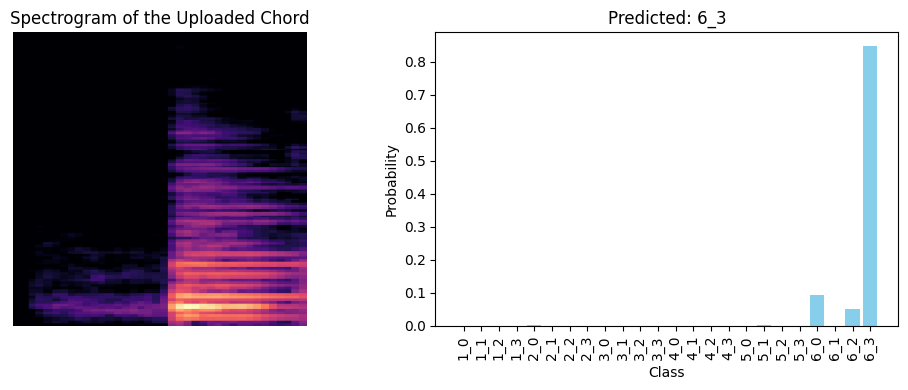

Predicted class: 6_3


'6_3'

In [ ]:
total_class_names = len(class_names)
class_key = random.randint(0, total_class_names)

target_dir = "Notes/test/" + class_names[class_key]
random_note = random.choice(os.listdir(target_dir))
random_note_path = target_dir + "/" + random_note
predict_and_plot_from_wav_file(random_note_path, model, train_ds.class_indices )

## 8. Guardar y descargar modelo

In [ ]:
from google.colab import files
model.save("notes.h5")
files.download('notes.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>